# Explore Pangeo tools for InSAR Post-processing

*** WANT to know:
- best practice for saving as Zarr store (chunking, compression)
- What advantage in performance over Geotiff?
- There is a lot of momentum building to store images as COGs on cloud storage. These are already tiled (same as chunked I believe)? So is it possible to create a Zarr Group wrapper that allows use of Dask without duplicating the data or downloading locally?

In [58]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr
import rasterio
import rasterio.plot
print('zarr version: ', zarr.__version__)
print('rasterio version: ', rasterio.__version__)
print(xr.__version__)

%matplotlib inline

zarr version:  2.2.0
rasterio version:  1.0.0
0.10.8


In [6]:
# Data
path = '/Users/scott/Data/pangeo/87'
os.listdir(path)[:10]

['20180628-20180616-unw.geo.tif',
 '20180511-20180505-unw.geo.tif',
 '20180529-20180505-unw.geo.tif',
 '20180604-20180523-unw.geo.tif',
 '20180604-20180511-unw.geo.tif',
 '20180523-20180505-unw.geo.tif',
 '20180622-20180616-unw.geo.tif',
 '20180616-20180604-unw.geo.tif',
 '20180423-20180411-unw.geo.tif',
 '20180716-20180710-unw.geo.tif']

In [9]:
# Start locally with a single image
# 20180622-20180529 has some interesting eruption-related features
pair = '20180622-20180529'
imgPath = f'{path}/{pair}-unw.geo.tif'
da = xr.open_rasterio(imgPath)

In [10]:
da

<xarray.DataArray (band: 1, y: 6080, x: 4457)>
[27098560 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 20.16 20.16 20.16 20.16 20.16 20.16 20.16 20.16 ...
  * x        (x) float64 -155.6 -155.6 -155.6 -155.6 -155.6 -155.6 -155.6 ...
Attributes:
    transform:   (0.0002777777777777778, 0.0, -155.62805555555556, 0.0, -0.00...
    crs:         +init=epsg:4326
    res:         (0.0002777777777777778, 0.0002777777777777778)
    is_tiled:    1
    nodatavals:  (nan,)

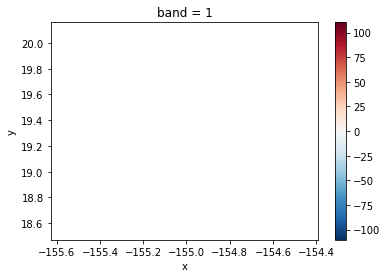

In [29]:
# metadata got lumpted into attributes, probably don't need float64 precision or band dimension
da.plot() 

#Doesn't work -> easy to change how data is loaded in? #QuadMesh instead of imshow
# See below for accessing band1 data

In [12]:
xr.open_rasterio?

Signature: xr.open_rasterio(filename, parse_coordinates=None, chunks=None, cache=None, lock=None)
Docstring:
Open a file with rasterio (experimental).

This should work with any file that rasterio can open (most often:
geoTIFF). The x and y coordinates are generated automatically from the
file's geoinformation, shifted to the center of each pixel (see
`"PixelIsArea" Raster Space
<http://web.archive.org/web/20160326194152/http://remotesensing.org/geotiff/spec/geotiff2.5.html#2.5.2>`_
for more information).

You can generate 2D coordinates from the file's attributes with::

    from affine import Affine
    da = xr.open_rasterio('path_to_file.tif')
    transform = Affine(*da.attrs['transform'])
    nx, ny = da.sizes['x'], da.sizes['y']
    x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform


Parameters
----------
filename : str
    Path to the file to open.
parse_coordinates : bool, optional
    Whether to parse the x and y coordinates out of the file's
    ``transform`

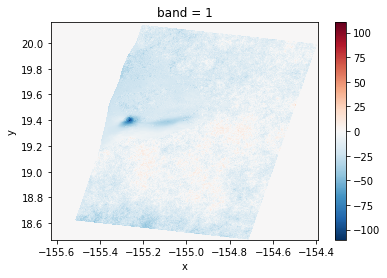

In [28]:
da.isel(band=0).plot.imshow()

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4457, 'height': 6080, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0002777777777777778, 0.0, -155.62805555555556,
       0.0, -0.0002777777777777778, 20.16), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


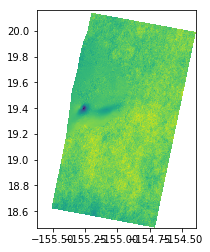

In [23]:
# Open with rasterio, to make sure files saved correctly initally:
with rasterio.open(imgPath) as src:
    print(src.profile)
    phs = src.read()
    rasterio.plot.show(src)

In [31]:
from rasterio.shutil import copy

In [40]:
%%time
# NOTE: this is slow compared to reading zip:// b/c reads entire zipfile into memory each time?
# As opposed to the 'zip://access, this reads in the entire zipfile to memory (can come direct from S3!)'
# without any need for hard disk - e.g. "Serverless applications"
from rasterio.io import ZipMemoryFile
zipdir = '/Users/scott/Data/pangeo/zips'
zipfile = 'S1-IFG_RM_M1S1_TN087_20170504T161627-20170410T161559_s1-poeorb-240c-v1.1.3-standard.unw_geo.zip'
fp = open(f'{zipdir}/{zipfile}', 'rb')

with ZipMemoryFile(fp) as zipmem:
    with zipmem.open('filt_topophase.unw.geo') as src:
        print(src.profile)

{'driver': 'ENVI', 'dtype': 'float32', 'nodata': None, 'width': 4457, 'height': 6081, 'count': 2, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0002777777777777778, -0.0, -155.62916666666666,
       -0.0, -0.0002777777777777778, 20.159444444444446), 'tiled': False, 'interleave': 'line'}
CPU times: user 3.31 ms, sys: 273 ms, total: 276 ms
Wall time: 274 ms


In [39]:
%%time
fullpath = f'zip://{zipdir}/{zipfile}!filt_topophase.unw.geo'
with rasterio.open(fullpath) as src:
    print(src.profile)

{'driver': 'ENVI', 'dtype': 'float32', 'nodata': None, 'width': 4457, 'height': 6081, 'count': 2, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0002777777777777778, -0.0, -155.62916666666666,
       -0.0, -0.0002777777777777778, 20.159444444444446), 'tiled': False, 'interleave': 'line'}
CPU times: user 2.9 ms, sys: 1.58 ms, total: 4.48 ms
Wall time: 2.89 ms


In [ ]:
# Read same file w/ common grid geotiff
test = '/Users/scott/Data/pangeo/zips/20180523-20180511-unw.geo.tif'
with rasterio.open(test) as src:
    print(src.profile)
    phs = src.read()
    rasterio.plot.show(src)

In [43]:
# Try to read all of these into a Xarray dataset
# NOTE: make VRT w/ all of them
path = '/Users/scott/Data/pangeo/zips'
pair = '20180622-20180529'
imgPath = f'{path}/{pair}-unw.geo.tif'
da = xr.open_rasterio(imgPath)
da

<xarray.DataArray (band: 1, y: 5220, x: 4860)>
[25369200 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 ...
  * x        (x) float64 -156.1 -156.1 -156.1 -156.1 -156.1 -156.1 -156.1 ...
Attributes:
    transform:   (0.00027777777777777664, 0.0, -156.1, 0.0, -0.00027777777777...
    crs:         +init=epsg:4326
    res:         (0.00027777777777777664, 0.0002777777777777776)
    is_tiled:    1
    nodatavals:  (nan,)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4860, 'height': 5220, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.00027777777777777664, 0.0, -156.1,
       0.0, -0.0002777777777777776, 20.3), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


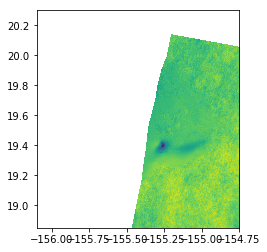

In [44]:
with rasterio.open(imgPath) as src:
    print(src.profile)
    phs = src.read()
    rasterio.plot.show(src)

In [46]:
# 75 geotiffs!
#os.system('gdalbuildvrt -separate hawaii-87.vrt *.tif')
with rasterio.open(path + '/hawaii-87.vrt') as src:
    print(src.profile)

{'driver': 'VRT', 'dtype': 'float32', 'nodata': None, 'width': 4860, 'height': 5220, 'count': 78, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.00027777777777777637, 0.0, -156.1,
       0.0, -0.00027777777777777734, 20.3), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}


In [50]:
da = xr.open_rasterio(path + '/hawaii-87.vrt', chunks=(512,512))
da
# Didn't actually create Dask array, but also no error?
#Dask.array<stack, shape=(119, 1350, 1350), dtype=float32, chunksize=(1, 1350, 1350)>

<xarray.DataArray (band: 78, y: 5220, x: 4860)>
[1978797600 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) float64 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 ...
  * x        (x) float64 -156.1 -156.1 -156.1 -156.1 -156.1 -156.1 -156.1 ...
Attributes:
    transform:   (0.00027777777777777637, 0.0, -156.1, 0.0, -0.00027777777777...
    crs:         +init=epsg:4326
    res:         (0.00027777777777777637, 0.00027777777777777734)
    is_tiled:    1
    nodatavals:  (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,...

In [56]:
#da = xr.open_rasterio(path + '/hawaii-87.vrt', chunks=(1,512,512))
# Add some attributes common to the set
setMetaData = dict(description='Hawaii 87 Timeseries',
                   created=pd.to_datetime('today'),
                   data='GRFN (beta)',
                   contact='scottyh@uw.edu',
                   ISCE='2.1.0')
da.attrs = setMetaData

In [57]:
da

<xarray.DataArray (band: 78, y: 5220, x: 4860)>
[1978797600 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) float64 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 ...
  * x        (x) float64 -156.1 -156.1 -156.1 -156.1 -156.1 -156.1 -156.1 ...
Attributes:
    description:  Hawaii 87 Timeseries
    created:      2018-08-13 08:00:44.771059
    data:         GRFN (beta)
    contact:      scottyh@uw.edu
    ISCE:         2.1.0

In [92]:
# NOTE: could add different Dataset variables such as coherence, radiometric amplitude....
# How can we be how each file got mapped to each band?
# More manual approach:
paths = glob.glob(f'{path}/*.tif')
tifs = [os.path.basename(x) for x in paths]
pairs = [x[:17] for x in tifs]
df = pd.DataFrame(dict(pair=pairs))
df['primary'] = pd.to_datetime(df.pair.str[:8])
df['secondary'] = pd.to_datetime(df.pair.str[-8:])
df['tif'] = paths
df = df.sort_values(['primary','secondary']).reset_index(drop=True)
df.head()

,pair,primary,secondary,tif
0,20170504-20170410,2017-05-04,2017-04-10,/Users/scott/Data/pangeo/zips/20170504-2017041...
1,20170504-20170422,2017-05-04,2017-04-22,/Users/scott/Data/pangeo/zips/20170504-2017042...
2,20170504-20170428,2017-05-04,2017-04-28,/Users/scott/Data/pangeo/zips/20170504-2017042...
3,20170510-20170422,2017-05-10,2017-04-22,/Users/scott/Data/pangeo/zips/20170510-2017042...
4,20170510-20170428,2017-05-10,2017-04-28,/Users/scott/Data/pangeo/zips/20170510-2017042...


In [96]:
# Much slower compared to loading the VRT directly?!
datasets = []
for i,row in df.iterrows():
    da = xr.open_rasterio(row.tif)
    datasets.append(da)
    
DS = xr.concat(datasets, dim='band')

In [ ]:
# Add a water mask as coordinate array


In [87]:
stack = ds.where(ds.mask == False).mean(dim='pair').load() # only prepares computation
stack.plot() #NOTE: distinct ramp across scene.